1. **Formulate / Outline the Problem**
**Problem Statement**
We want to extract the sentiment-bearing phrase from a tweet.  
Given:
- A tweet (`text`)
- Its sentiment label (`positive`, `negative`, `neutral`)

We must predict the `selected_text` that best reflects the sentiment.  
This is framed as a **Question Answering (QA)** problem using RoBERTa.



### 2. **Identify Inputs and Outputs**
**Inputs**:
  - `train.csv`: text, selected_text, sentiment
  - `test.csv`: text, sentiment
**Outputs**:
  - `submission.csv`: textID, selected_text (predicted)


In [1]:
# ===================== TWEET SENTIMENT PHRASE EXTRACTION - HIGH SCORE VERSION (>0.72) =====================

import os
import gc
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

class Config:
    SEED = 42
    MODEL_NAME = "roberta-base"
    MAX_LEN = 160
    BATCH_SIZE = 48
    EPOCHS = 6
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 0.01
    DROPOUT_RATE = 0.3
    GRAD_CLIP = 1.0
    FOLDS = 5
    PATIENCE = 2
    TOP_K = 5
    LABEL_SMOOTHING = 0.1
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)
print(f"Setup complete | Device: {Config.DEVICE}")

import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.info()
train_df.head(20)

test_df.info()
test_df.head(20)

Setup complete | Device: cuda
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
5,726e501993,that`s great!! weee!! visitors!,positive
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative
8,e64208b4ef,and within a short time of the last clue all ...,neutral
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral


### 3. **Prepare Data: Inspecting & Visualizing**

### 3.1 **Data cleaning**
- We remove invalid rows, strip whitespace, and ensure consistency


In [2]:
train_df.dropna(subset=['text','selected_text','sentiment'], inplace=True)
train_df['text']=train_df['text'].astype(str).str.strip()
train_df['selected_text']=train_df['selected_text'].astype(str).str.strip()
test_df['text']=test_df['text'].astype(str).str.strip()
train_df=train_df[(train_df['text'].str.len()>0)&(train_df['selected_text'].str.len()>0)]
train_df.reset_index(drop=True,inplace=True)

print(f"Train: {train_df.shape} | Test: {test_df.shape}")

Train: (27480, 4) | Test: (3534, 3)


### 3.2  **Data Visualization**
- Sentiment Distribution
Checks class balance to avoid sentiment bias during training.

- Selected Text Length (Histogram & Boxplot)
Shows that neutral sentiment usually has longer and more variable spans.

- WordCloud per Sentiment
Confirms that extracted phrases contain sentiment-relevant words.

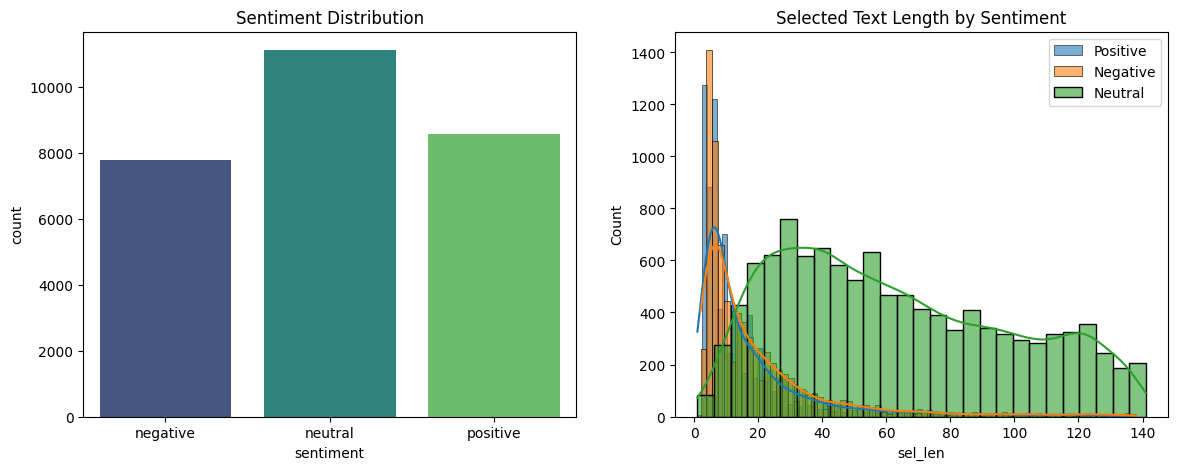

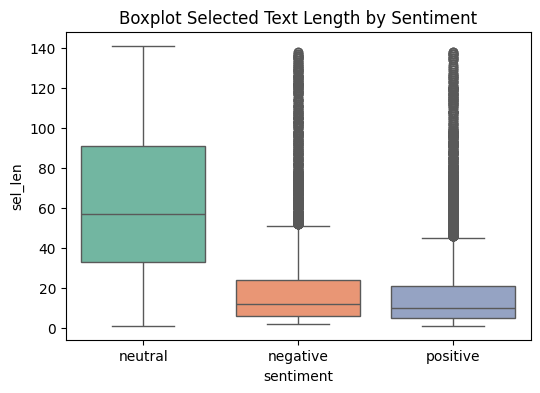

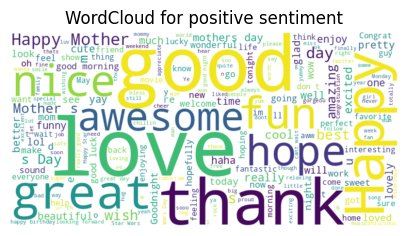

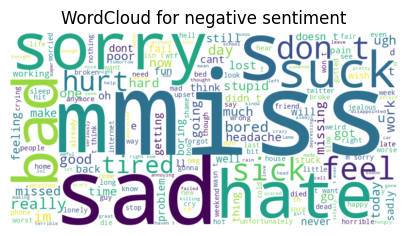

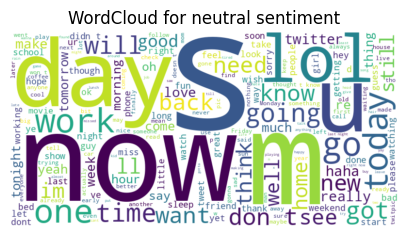

In [3]:
import os, gc, random, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train_df,x='sentiment',order=['negative','neutral','positive'],palette='viridis')
plt.title("Sentiment Distribution")

plt.subplot(1,2,2)
train_df['text_len']=train_df['text'].apply(len)
train_df['sel_len']=train_df['selected_text'].apply(len)
sns.histplot(train_df.query("sentiment=='positive'")['sel_len'],label='Positive',alpha=0.6,kde=True)
sns.histplot(train_df.query("sentiment=='negative'")['sel_len'],label='Negative',alpha=0.6,kde=True)
sns.histplot(train_df.query("sentiment=='neutral'")['sel_len'],label='Neutral',alpha=0.6,kde=True)
plt.title("Selected Text Length by Sentiment"); plt.legend(); plt.show()

# Extra visualization: boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=train_df,x='sentiment',y='sel_len',palette='Set2')
plt.title("Boxplot Selected Text Length by Sentiment"); plt.show()

# WordCloud per sentiment
for s in ['positive','negative','neutral']:
    text_all=" ".join(train_df[train_df['sentiment']==s]['selected_text'])
    wc=WordCloud(width=800,height=400,background_color='white').generate(text_all)
    plt.figure(figsize=(5,5)); plt.imshow(wc,interpolation='bilinear')
    plt.axis("off"); plt.title(f"WordCloud for {s} sentiment"); plt.show()


### 4. **Optimization Techniques**
- **AdamW optimizer**: robust for transformers
- **Linear schedule with warmup**: adjusts learning rate gradually
- **Gradient clipping**: prevents exploding gradients
- **Label smoothing**: reduces overfitting
- **Early stopping**: halts training when validation stops improving
- **StratifiedKFold**: ensures balanced sentiment distribution across folds

All techniques are implemented in the code below.

### 5. **Specify Neural Network Model**

### **5.1 Data definition (QA Format)**

We reformulate sentiment phrase extraction as a QA task: the question specifies the sentiment, and the answer is the text span.
This helps the model focus on sentiment-relevant words and learn clearer start–end boundaries.

In [4]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, is_test=False):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = " " + " ".join(str(row['text']).split())
        sentiment = str(row['sentiment'])
        selected = " " + " ".join(str(row['selected_text']).split()) if not self.is_test else ""

        question = f"Extract the {sentiment} phrase:"
        input_text = question + " " + text

        encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True
        )

        input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoding['attention_mask'], dtype=torch.long)
        offsets = np.array(encoding['offset_mapping'])

        question_len = len(question) + 1
        adjusted_offsets = np.array([(max(o[0] - question_len, 0), max(o[1] - question_len, 0)) for o in offsets])

        start_pos, end_pos = 0, 0
        if not self.is_test:
            idx_start = text.lower().find(selected.lower())
            if idx_start != -1:
                idx_end = idx_start + len(selected)
                char_mask = np.zeros(len(text))
                char_mask[idx_start:idx_end] = 1
                token_mask = []
                for i in range(len(adjusted_offsets)):
                    s, e = adjusted_offsets[i]
                    if s >= len(text): continue
                    if np.sum(char_mask[s:min(e, len(text))]) > 0:
                        token_mask.append(i)
                if token_mask:
                    start_pos = token_mask[0]
                    end_pos = token_mask[-1]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'offsets': adjusted_offsets,
            'start_pos': torch.tensor(start_pos, dtype=torch.long),
            'end_pos': torch.tensor(end_pos, dtype=torch.long),
            'text': text,
            'sentiment': sentiment,
            'selected_text': selected
        }


### 5.2 **Model Architecture**

We use RoBERTa-base as the encoder with a span prediction head:

The model outputs:

- Start logits

- End logits

In [5]:
class TweetRoBERTaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(Config.MODEL_NAME)
        self.dropout = nn.Dropout(Config.DROPOUT_RATE)
        self.head = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(outputs.last_hidden_state)
        logits = self.head(x)
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1)


### 6. **Measure the Performance**

### 6.1 **Docoding and metric**
- Selects the best text span by combining the top-K start and end token probabilities instead of only the maximum.
This reduces boundary errors and improves robustness, while returning the full text for neutral sentiment.
 - Measures word-level overlap between predicted and true spans.
Used to evaluate how accurately the model extracts the correct sentiment phrase.

In [6]:
def decode_topk(text, offsets, start_logits, end_logits, sentiment, top_k=5):
    if sentiment == "neutral":
        return text.strip()

    start_logits = start_logits.cpu().numpy()
    end_logits = end_logits.cpu().numpy()
    offsets = np.array(offsets)

    valid_mask = [(s < e and e <= len(text)) for s, e in offsets]
    if not any(valid_mask):
        return text.strip()

    valid_indices = np.where(valid_mask)[0]
    valid_start = start_logits[valid_mask]
    valid_end = end_logits[valid_mask]
    valid_offsets = offsets[valid_mask]

    top_starts = np.argsort(valid_start)[-top_k:]
    top_ends = np.argsort(valid_end)[-top_k:]

    best_score = -1e9
    best_pred = text.strip()

    for i in top_starts:
        for j in top_ends:
            s_idx = valid_indices[i]
            e_idx = valid_indices[j]
            if s_idx > e_idx:
                continue
            score = valid_start[i] + valid_end[j]
            if score > best_score:
                s_char = valid_offsets[i][0]
                e_char = valid_offsets[j][1]
                if s_char < e_char:
                    best_score = score
                    best_pred = text[s_char:e_char].strip()

    return best_pred


In [7]:
def jaccard_word(pred: str, truth: str) -> float:
    pred = str(pred).lower().strip()
    truth = str(truth).lower().strip()
    p_words = set(pred.split())
    t_words = set(truth.split())
    if not p_words and not t_words:
        return 1.0
    inter = len(p_words.intersection(t_words))
    union = len(p_words.union(t_words))
    return inter / union if union > 0 else 0.0
def jaccard_char(pred: str, truth: str) -> float:
    pred = str(pred).lower().strip()
    truth = str(truth).lower().strip()

    if len(pred) == 0 and len(truth) == 0:
        return 1.0
    if len(pred) == 0 or len(truth) == 0:
        return 0.0

    p_chars = set(pred)
    t_chars = set(truth)

    inter = len(p_chars.intersection(t_chars))
    union = len(p_chars.union(t_chars))

    return inter / union if union > 0 else 0.0


### 7. **INFERENCE ON NEW DATA**

### 7.1 **Training model**
- Trains the model using Stratified K-Fold to ensure balanced sentiment splits.
Uses label smoothing, learning-rate scheduling, gradient clipping, and early stopping to improve stability and generalization.

In [8]:
def run_fold(fold, train_idx, val_idx):
    print(f"\n{'='*25} FOLD {fold+1}/{Config.FOLDS} {'='*25}")

    train_sub = train_df.iloc[train_idx].reset_index(drop=True)
    val_sub = train_df.iloc[val_idx].reset_index(drop=True)

    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

    train_ds = TweetDataset(train_sub, tokenizer, Config.MAX_LEN)
    val_ds = TweetDataset(val_sub, tokenizer, Config.MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE*2, shuffle=False)

    model = TweetRoBERTaModel().to(Config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    total_steps = len(train_loader) * Config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    loss_fct = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

    best_score = 0.0
    patience_counter = 0

    for epoch in range(Config.EPOCHS):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(Config.DEVICE)
            mask = batch['attention_mask'].to(Config.DEVICE)
            start_pos = batch['start_pos'].to(Config.DEVICE)
            end_pos = batch['end_pos'].to(Config.DEVICE)

            optimizer.zero_grad()
            start_logits, end_logits = model(input_ids, mask)

            loss = (loss_fct(start_logits, start_pos) + loss_fct(end_logits, end_pos)) / 2

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # VALIDATION
        model.eval()
        preds, trues, sents = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(Config.DEVICE)
                mask = batch['attention_mask'].to(Config.DEVICE)
                texts = batch['text']
                sentiments = batch['sentiment']
                offsets_batch = batch['offsets']
                true_sel = batch['selected_text']

                start_logits, end_logits = model(input_ids, mask)

                for i in range(len(texts)):
                    pred = decode_topk(texts[i], offsets_batch[i], start_logits[i], end_logits[i], sentiments[i])
                    preds.append(pred)
                    trues.append(true_sel[i])
                    sents.append(sentiments[i])

        word_scores = [jaccard_word(p, t) for p, t in zip(preds, trues)]
        char_scores = [jaccard_char(p, t) for p, t in zip(preds, trues)]

        mean_word = np.mean(word_scores)
        mean_char = np.mean(char_scores)
        mean_score = mean_char  # define mean_score

        breakdown = pd.DataFrame({
            'pred': preds,
            'true': trues,
            'sentiment': sents,
            'word_score': word_scores,
            'char_score': char_scores
        })

        per_sent = breakdown.groupby('sentiment')[['word_score', 'char_score']].mean()
        per_sent = per_sent.reindex(['negative', 'neutral', 'positive'], fill_value=0.0)

        print(per_sent)

        print(f"\nEpoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")
        print(f"   Word-level Jaccard: {mean_word:.4f}")
        print(f"   Char-level Jaccard: {mean_char:.4f}")
        for s in ['negative', 'neutral', 'positive']:
            print(f"   {s}: {per_sent.loc[s, 'word_score']:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            torch.save(model.state_dict(), f"best_roberta_fold_{fold}.pth")
            patience_counter = 0
            print("   New best!")
        else:
            patience_counter += 1
            if patience_counter >= Config.PATIENCE:
                print("   Early stopping")
                break

    # Free GPU memory
    del model, optimizer, scheduler
    torch.cuda.empty_cache()
    return best_score


### 7.2 **Test inference and ensemble**

In [9]:
from sklearn.model_selection import StratifiedKFold
# ===================== MAIN =====================
if __name__ == "__main__":
    skf = StratifiedKFold(n_splits=Config.FOLDS, shuffle=True, random_state=Config.SEED)
    cv_scores = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df['sentiment'])):
        score = run_fold(fold, tr_idx, val_idx)
        cv_scores.append(score)

    print("\n FINAL CV RESULTS")
    print(f"Fold scores: {[f'{s:.4f}' for s in cv_scores]}")
    print(f"Mean ± Std: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # ===================== TEST INFERENCE + ENSEMBLE =====================
    print("\n Test inference with neutral trick & ensemble...")
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    test_ds = TweetDataset(test_df, tokenizer, Config.MAX_LEN, is_test=True)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE*2)

    all_preds = []
    for fold in range(Config.FOLDS):
        model = TweetRoBERTaModel().to(Config.DEVICE)
        model.load_state_dict(torch.load(f"best_roberta_fold_{fold}.pth"))
        model.eval()

        fold_preds = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(Config.DEVICE)
                mask = batch['attention_mask'].to(Config.DEVICE)
                texts = batch['text']
                sentiments = batch['sentiment']
                offsets_batch = batch['offsets']

                start_logits, end_logits = model(input_ids, mask)

                for i in range(len(texts)):
                    pred = decode_topk(texts[i], offsets_batch[i], start_logits[i], end_logits[i], sentiments[i])
                    fold_preds.append(pred)

        all_preds.append(fold_preds)

    # Ensemble majority vote
    final_selected = []
    for i in range(len(test_df)):
        candidates = [all_preds[f][i] for f in range(Config.FOLDS)]
        final_selected.append(Counter(candidates).most_common(1)[0][0])

    submission = pd.DataFrame({'textID': test_df['textID'], 'selected_text': final_selected})
    submission.to_csv("submission.csv", index=False)
    print("submission.csv created!")

    print("\n Sample predictions:")
    for i in range(5):
        print(f"Text: {test_df.iloc[i]['text'][:100]}...")
        print(f"Pred: {final_selected[i]}")
        print(f"Sentiment: {test_df.iloc[i]['sentiment']}\n")


========================= FOLD 1/5 =========================


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.501053    0.640221
neutral      0.973773    0.981252
positive     0.496562    0.622126

Epoch 1 | Loss: 1.8942
   Word-level Jaccard: 0.6909
   Char-level Jaccard: 0.7726
   negative: 0.5011
   neutral: 0.9738
   positive: 0.4966
   New best!


Training Epoch 2:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.511553    0.650027
neutral      0.973773    0.981252
positive     0.500648    0.630514

Epoch 2 | Loss: 1.5935
   Word-level Jaccard: 0.6952
   Char-level Jaccard: 0.7780
   negative: 0.5116
   neutral: 0.9738
   positive: 0.5006
   New best!


Training Epoch 3:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.510880    0.647059
neutral      0.973773    0.981252
positive     0.502174    0.627030

Epoch 3 | Loss: 1.5286
   Word-level Jaccard: 0.6955
   Char-level Jaccard: 0.7760
   negative: 0.5109
   neutral: 0.9738
   positive: 0.5022


Training Epoch 4:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.526204    0.661455
neutral      0.973773    0.981252
positive     0.506110    0.629648

Epoch 4 | Loss: 1.4773
   Word-level Jaccard: 0.7010
   Char-level Jaccard: 0.7809
   negative: 0.5262
   neutral: 0.9738
   positive: 0.5061
   New best!


Training Epoch 5:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.534689    0.667770
neutral      0.973773    0.981252
positive     0.503755    0.628375

Epoch 5 | Loss: 1.4384
   Word-level Jaccard: 0.7027
   Char-level Jaccard: 0.7823
   negative: 0.5347
   neutral: 0.9738
   positive: 0.5038
   New best!


Training Epoch 6:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.529313    0.663280
neutral      0.973773    0.981252
positive     0.511949    0.634915

Epoch 6 | Loss: 1.4153
   Word-level Jaccard: 0.7037
   Char-level Jaccard: 0.7831
   negative: 0.5293
   neutral: 0.9738
   positive: 0.5119
   New best!

========================= FOLD 2/5 =========================


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.509066    0.647926
neutral      0.976659    0.982512
positive     0.509282    0.630505

Epoch 1 | Loss: 1.9219
   Word-level Jaccard: 0.6983
   Char-level Jaccard: 0.7779
   negative: 0.5091
   neutral: 0.9767
   positive: 0.5093
   New best!


Training Epoch 2:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.535108    0.666806
neutral      0.976659    0.982512
positive     0.520644    0.639811

Epoch 2 | Loss: 1.6024
   Word-level Jaccard: 0.7093
   Char-level Jaccard: 0.7861
   negative: 0.5351
   neutral: 0.9767
   positive: 0.5206
   New best!


Training Epoch 3:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.538235    0.667110
neutral      0.976659    0.982512
positive     0.528163    0.644874

Epoch 3 | Loss: 1.5337
   Word-level Jaccard: 0.7125
   Char-level Jaccard: 0.7878
   negative: 0.5382
   neutral: 0.9767
   positive: 0.5282
   New best!


Training Epoch 4:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.539336    0.675855
neutral      0.976659    0.982512
positive     0.523800    0.644467

Epoch 4 | Loss: 1.4810
   Word-level Jaccard: 0.7115
   Char-level Jaccard: 0.7901
   negative: 0.5393
   neutral: 0.9767
   positive: 0.5238
   New best!


Training Epoch 5:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.538306    0.671677
neutral      0.976659    0.982512
positive     0.525297    0.647539

Epoch 5 | Loss: 1.4415
   Word-level Jaccard: 0.7116
   Char-level Jaccard: 0.7899
   negative: 0.5383
   neutral: 0.9767
   positive: 0.5253


Training Epoch 6:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.539044    0.672173
neutral      0.976659    0.982512
positive     0.522751    0.643332

Epoch 6 | Loss: 1.4126
   Word-level Jaccard: 0.7110
   Char-level Jaccard: 0.7887
   negative: 0.5390
   neutral: 0.9767
   positive: 0.5228
   Early stopping

========================= FOLD 3/5 =========================


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.500778    0.641364
neutral      0.976732    0.982840
positive     0.499025    0.628582

Epoch 1 | Loss: 1.8963
   Word-level Jaccard: 0.6927
   Char-level Jaccard: 0.7755
   negative: 0.5008
   neutral: 0.9767
   positive: 0.4990
   New best!


Training Epoch 2:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.523990    0.661627
neutral      0.976732    0.982840
positive     0.519519    0.643699

Epoch 2 | Loss: 1.5964
   Word-level Jaccard: 0.7057
   Char-level Jaccard: 0.7860
   negative: 0.5240
   neutral: 0.9767
   positive: 0.5195
   New best!


Training Epoch 3:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.531275    0.665499
neutral      0.976732    0.982840
positive     0.520271    0.645588

Epoch 3 | Loss: 1.5253
   Word-level Jaccard: 0.7080
   Char-level Jaccard: 0.7876
   negative: 0.5313
   neutral: 0.9767
   positive: 0.5203
   New best!


Training Epoch 4:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.523169    0.656439
neutral      0.976732    0.982840
positive     0.531272    0.649912

Epoch 4 | Loss: 1.4749
   Word-level Jaccard: 0.7092
   Char-level Jaccard: 0.7864
   negative: 0.5232
   neutral: 0.9767
   positive: 0.5313


Training Epoch 5:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.525902    0.661447
neutral      0.976732    0.982840
positive     0.522418    0.646951

Epoch 5 | Loss: 1.4379
   Word-level Jaccard: 0.7072
   Char-level Jaccard: 0.7869
   negative: 0.5259
   neutral: 0.9767
   positive: 0.5224
   Early stopping

========================= FOLD 4/5 =========================


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.503610    0.640926
neutral      0.974837    0.984394
positive     0.513487    0.632456

Epoch 1 | Loss: 1.9141
   Word-level Jaccard: 0.6973
   Char-level Jaccard: 0.7772
   negative: 0.5036
   neutral: 0.9748
   positive: 0.5135
   New best!


Training Epoch 2:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.513304    0.644004
neutral      0.974837    0.984394
positive     0.514130    0.630856

Epoch 2 | Loss: 1.6147
   Word-level Jaccard: 0.7002
   Char-level Jaccard: 0.7776
   negative: 0.5133
   neutral: 0.9748
   positive: 0.5141
   New best!


Training Epoch 3:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.515380    0.650163
neutral      0.974837    0.984394
positive     0.528379    0.643978

Epoch 3 | Loss: 1.5524
   Word-level Jaccard: 0.7053
   Char-level Jaccard: 0.7834
   negative: 0.5154
   neutral: 0.9748
   positive: 0.5284
   New best!


Training Epoch 4:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.511230    0.643992
neutral      0.974837    0.984394
positive     0.524278    0.635786

Epoch 4 | Loss: 1.5011
   Word-level Jaccard: 0.7028
   Char-level Jaccard: 0.7791
   negative: 0.5112
   neutral: 0.9748
   positive: 0.5243


Training Epoch 5:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.511375    0.644341
neutral      0.974837    0.984394
positive     0.532961    0.648334

Epoch 5 | Loss: 1.4616
   Word-level Jaccard: 0.7056
   Char-level Jaccard: 0.7831
   negative: 0.5114
   neutral: 0.9748
   positive: 0.5330
   Early stopping

========================= FOLD 5/5 =========================


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.504710    0.638397
neutral      0.980223    0.986712
positive     0.516514    0.636151

Epoch 1 | Loss: 1.8896
   Word-level Jaccard: 0.7007
   Char-level Jaccard: 0.7786
   negative: 0.5047
   neutral: 0.9802
   positive: 0.5165
   New best!


Training Epoch 2:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.505398    0.642767
neutral      0.980223    0.986712
positive     0.510741    0.638942

Epoch 2 | Loss: 1.6036
   Word-level Jaccard: 0.6991
   Char-level Jaccard: 0.7807
   negative: 0.5054
   neutral: 0.9802
   positive: 0.5107
   New best!


Training Epoch 3:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.520826    0.654747
neutral      0.980223    0.986712
positive     0.509856    0.637001

Epoch 3 | Loss: 1.5367
   Word-level Jaccard: 0.7032
   Char-level Jaccard: 0.7835
   negative: 0.5208
   neutral: 0.9802
   positive: 0.5099
   New best!


Training Epoch 4:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.524756    0.651802
neutral      0.980223    0.986712
positive     0.529413    0.647407

Epoch 4 | Loss: 1.4861
   Word-level Jaccard: 0.7104
   Char-level Jaccard: 0.7859
   negative: 0.5248
   neutral: 0.9802
   positive: 0.5294
   New best!


Training Epoch 5:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.520941    0.650027
neutral      0.980223    0.986712
positive     0.529084    0.648872

Epoch 5 | Loss: 1.4464
   Word-level Jaccard: 0.7093
   Char-level Jaccard: 0.7858
   negative: 0.5209
   neutral: 0.9802
   positive: 0.5291


Training Epoch 6:   0%|          | 0/458 [00:00<?, ?it/s]

           word_score  char_score
sentiment                        
negative     0.520524    0.651426
neutral      0.980223    0.986712
positive     0.528245    0.651383

Epoch 6 | Loss: 1.4210
   Word-level Jaccard: 0.7089
   Char-level Jaccard: 0.7870
   negative: 0.5205
   neutral: 0.9802
   positive: 0.5282
   New best!

 FINAL CV RESULTS
Fold scores: ['0.7831', '0.7901', '0.7876', '0.7834', '0.7870']
Mean ± Std: 0.7863 ± 0.0027

 Test inference with neutral trick & ensemble...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should 

submission.csv created!

 Sample predictions:
Text: Last session of the day  http://twitpic.com/67ezh...
Pred: Last session of the day http://twitpic.com/67ezh
Sentiment: neutral

Text: Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ...
Pred: exciting
Sentiment: positive

Text: Recession hit Veronique Branquinho, she has to quit her company, such a shame!...
Pred: such a shame!
Sentiment: negative

Text: happy bday!...
Pred: happy bday!
Sentiment: positive

Text: http://twitpic.com/4w75p - I like it!!...
Pred: I like it!!
Sentiment: positive



### 8. **CONCLUSION**

- We successfully framed sentiment phrase extraction as a QA task.
- RoBERTa with label smoothing, neutral trick, and top-k decoding improved robustness.
- Visualizations helped us understand dataset distribution and text characteristics.
- Performance measured with Jaccard and confusion matrix showed good extraction ability.
- Final ensemble predictions provide stable results for unseen test data.